<a href="https://colab.research.google.com/github/TonyGlimm/Electricity-Production-Forecasting/blob/main/Electricity_Production_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
import pandas as pd 
import numpy as np

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


## Loading Data

In [3]:
col_names =['date', 'amount']
df = pd.read_csv('drive/My Drive/Colab Notebooks/data_electricity/Electric_Production.csv',names = col_names,header=0, parse_dates=[0])

df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df.head()

,amount
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


## Trying out Rolling Statistics a bit more

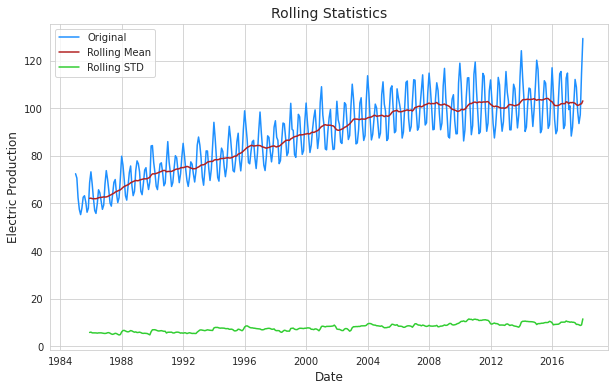

In [4]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()  
plt.figure(figsize =(10,6))
plt.plot(df, color='dodgerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label = 'Rolling Mean')
plt.plot(rolling_std, color='limegreen', label= 'Rolling STD')
plt.xlabel('Date', size=12)
plt.ylabel('Electric Production', size =12)
plt.legend(loc= 'upper left')
plt.title('Rolling Statistics', size =14)
plt.show()

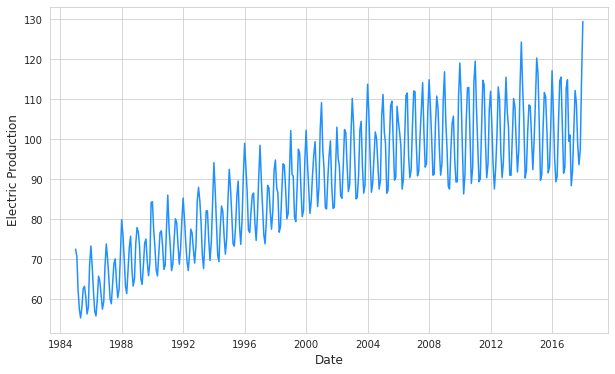

ADF Test Statistic : -2.2569903500472366
p-value : 0.18621469116587053
#Lags Used : 15
Number of Observations Used : 381
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [7]:
## checkking for stationarity



from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['amount'])
#H0 it is non stationary
#H1 it is stationary


def adfuller_test(Power):
  result=adfuller(Power)
  labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
      print(label+' : '+str(value) )
  if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
  else:
      print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['amount'])

plt.figure(figsize = (10,6))
plt.plot(df['amount'],color ='dodgerblue')
plt.xlabel('Date', size=12)
plt.ylabel('Electric Production', size =12)
plt.show()


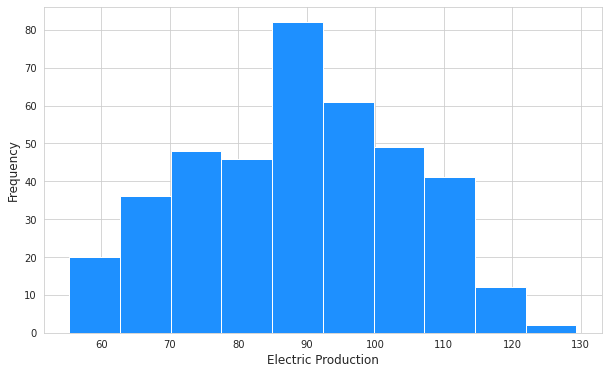

In [8]:
plt.figure(figsize = (10,6))
plt.hist(df['amount'], color = 'dodgerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [9]:
print("Data Shape: {}".format(df.shape))
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape: (397, 1)


In [12]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258
Variance of value_1: 123.226
Variance of value_2: 91.677


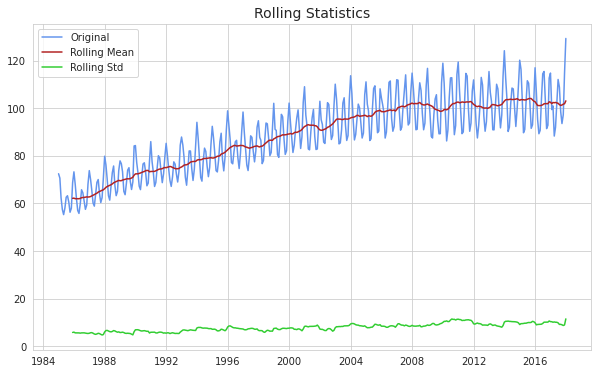

ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [13]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='dodgerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

## Converting data to stationary

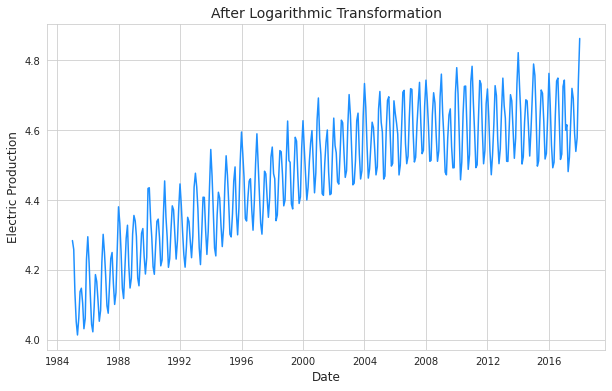

In [15]:
## logarithmich transformation with box-cox
# The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.
from scipy.stats import boxcox
df_log_scaled =df
df_log_scaled['amount'] = boxcox(df_log_scaled['amount'],lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color ='dodgerblue')
plt.xlabel('Date', size =12)
plt.ylabel('Electric Production', size=12)
plt.title('After Logarithmic Transformation', size =14)
plt.show()

# Removing Trend with moving average

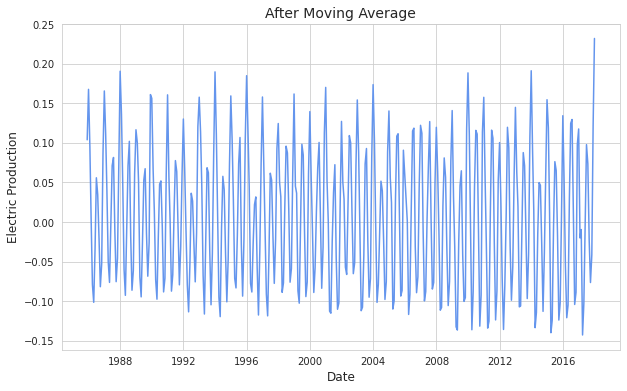

In [16]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

## Exponential Decay Transformation

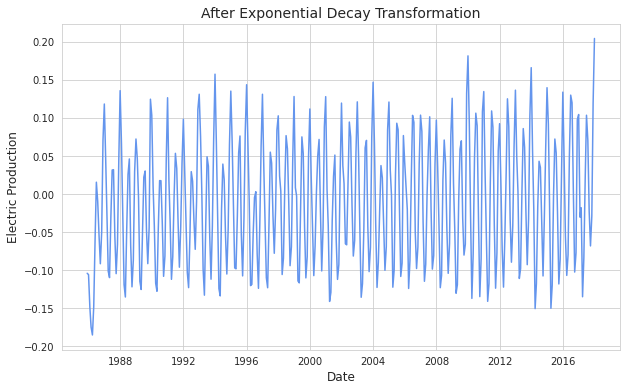

In [17]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
plt.figure(figsize = (10,6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()

## Test for stationarity again

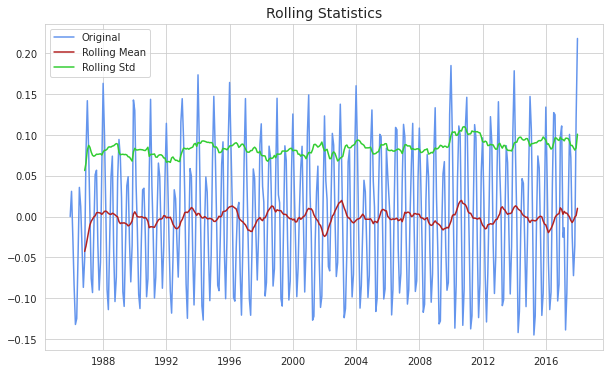

ADF Statistic: -7.213
p-value: 0.0
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [18]:
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

## Decomposition

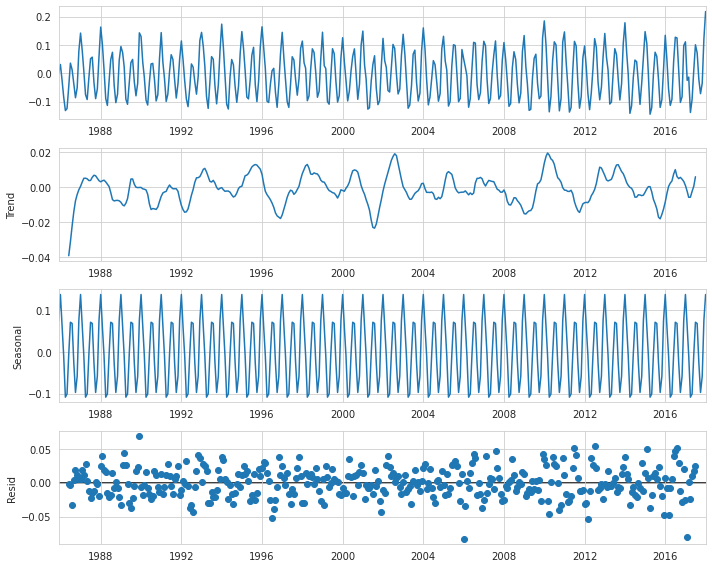

In [20]:
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed, 
                                           model='duplicative')
df_seasonal_decompose.plot()
plt.show()

## ACF & PACF

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


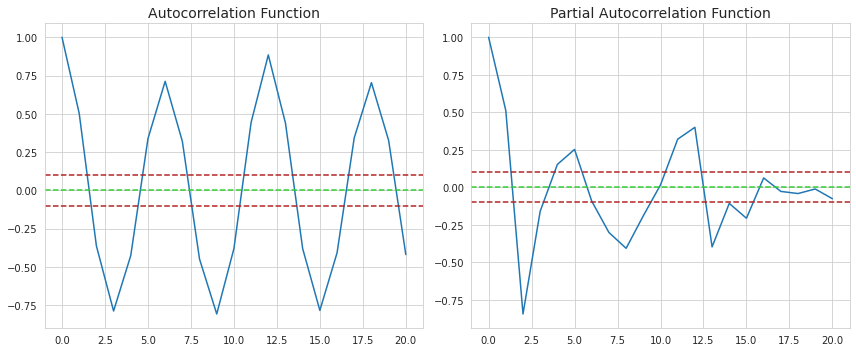

In [21]:
auto_c_f = acf(df_lsma_sub_df_lsma_ed, nlags=20)
partial_auto_c_f = pacf(df_lsma_sub_df_lsma_ed, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)            

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 

## Model

#### Predict 10 values 

### Autoregression Model

In [31]:
ar_values = df_lsma_sub_df_lsma_ed.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0211


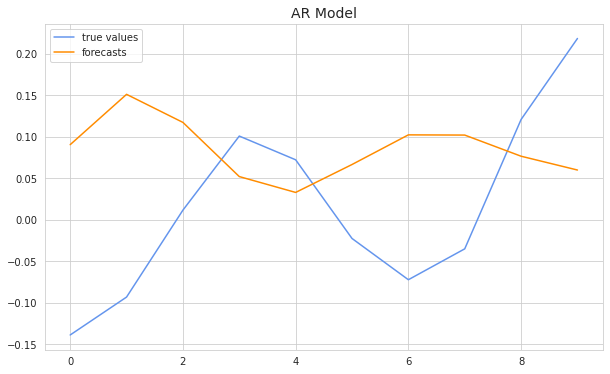

In [32]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

### Persistence Model

In [33]:
values = pd.DataFrame(df_lsma_sub_df_lsma_ed.values)
persistence_df = pd.concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

train = per_values[1:len(per_values)-10] 
test = per_values[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score,4)))

Persistence MSE: 0.0084


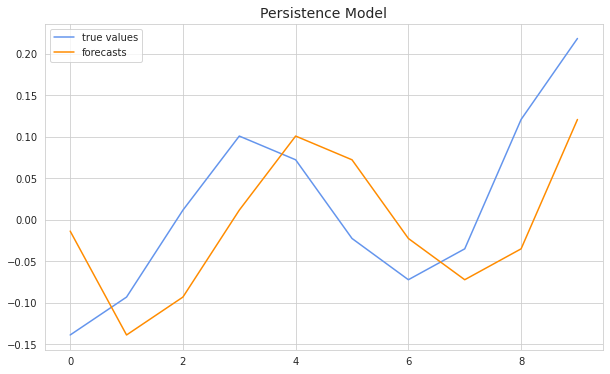

In [34]:
plt.figure(figsize = (10,6))
plt.plot(y_test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("Persistence Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

### Moving average model

In [36]:
ar_values = df_lsma_sub_df_lsma_ed.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.0117


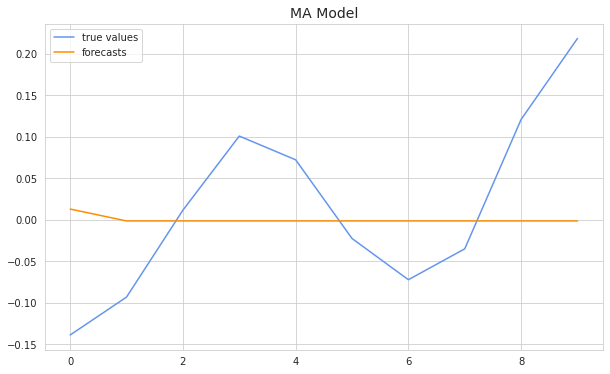

In [37]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

### ARIMA model

The statsmodels library provides the capability to fit an ARIMA model.
An ARIMA model can be created using the statsmodels library as follows:

1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire Electric Production dataset.

In [38]:
model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.0019


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


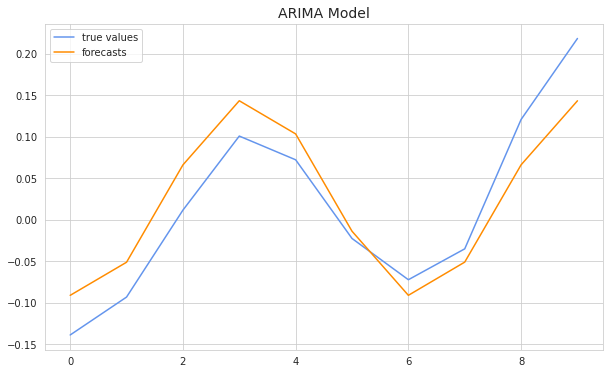

In [40]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [41]:
errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA"]
errors["MSE"] = [persistence_score, ar_score, ma_score, arima_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
ARIMA,0.001907
Persistence,0.008401
Moving Average,0.011716
Autoregression,0.021126
